In [1]:
from __future__ import division, print_function
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 150}

C:\Anaconda2\envs\unitarity-example\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We begin by importing NumPy and QuTiP. Note that we rely here on the 3.2.0 prerelease of QuTiP.

In [2]:
import numpy as np
import qutip as qt
from scipy.optimize import curve_fit
from functools import partial

In [3]:
import matplotlib.pyplot as plt
try: plt.style.use('ggplot')
except: pass

Next, we'll define the Clifford group $C_1$ as superoperators so that we can sample from it later.

In [4]:
clifford_group = [qt.to_super(U) for U in qt.qubit_clifford_group()]
len(clifford_group)

24

We can now define what a sequence is, given a particular noise map $\Lambda$.

In [5]:
def sequence(m, lambda_):
    gates = np.random.choice(clifford_group, size=(m))
    S_accumulator = qt.to_super(qt.qeye(2))
    
    for S in reversed(gates):
        S_accumulator *= lambda_ * S
    
    return S_accumulator

Given this definition, we are now equipped to define our experimental protocol for a preparation $\rho$ and a measurement $Q$. We will return the exact expectation, corresponding to the limit that very large numbers of shots are taken for each sequence. That is, we will consider only the between-sequence to the variance in each datum, and not the within-sequence variance.

In [6]:
def measure_sequence(S, rho, Q):
    return (Q * qt.vector_to_operator(S * qt.operator_to_vector(rho))).tr() ** 2

def measure_sequence_purity(S, rho):
    return (qt.vector_to_operator(S * qt.operator_to_vector(rho)) ** 2).tr()

For example, suppose that $\Lambda[\rho] = 0.99 e^{-0.001 \sigma_x}[\rho]e^{\text{h. c.}} + 0.01 \frac{\mathbb{1}}2$.

In [7]:
depol = qt.to_super(qt.Qobj(np.eye(4), dims=qt.to_super(qt.qeye(2)).dims, superrep='choi') / 2)
depol

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True
Qobj data =
[[ 0.5  0.   0.   0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.5  0.   0.   0.5]]

In [8]:
lambda_ = 0.99 * qt.to_super((-0.001j * qt.sigmax()).expm()) + 0.01 * depol
Q = qt.ket2dm(qt.basis(2, 0))
rho = qt.ket2dm(qt.basis(2, 0))

In [9]:
def unitarity_experiment(lambda_, ms, n_sequences_per_m, measurement_fn):
    us = np.empty_like(ms, dtype=float)
    progbar = qt.ui.TextProgressBar(len(ms))
    
    for idx_m, m in enumerate(ms):
        us[idx_m] = np.mean([
            measurement_fn(sequence(m, lambda_))
            for idx_sequence in range(n_sequences_per_m)
        ])
        progbar.update(idx_m + 1)
        
    return us

In [10]:
ms = np.arange(1, 101, 5)
print('=== Q ===')
q_measurements = unitarity_experiment(lambda_, ms, 300, partial(measure_sequence, rho=rho, Q=Q))
print('=== Purity ===')
purity_measurements = unitarity_experiment(lambda_, ms, 300, partial(measure_sequence_purity, rho=rho))

=== Q ===


C:\Anaconda2\envs\unitarity-example\lib\site-packages\ipykernel\__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


10.0%. Run time:   2.97s. Est. time left: 00:00:00:26
20.0%. Run time:   9.35s. Est. time left: 00:00:00:37
30.0%. Run time:  20.64s. Est. time left: 00:00:00:48
40.0%. Run time:  32.39s. Est. time left: 00:00:00:48
50.0%. Run time:  46.91s. Est. time left: 00:00:00:46
60.0%. Run time:  66.63s. Est. time left: 00:00:00:44
70.0%. Run time:  86.70s. Est. time left: 00:00:00:37
80.0%. Run time: 112.90s. Est. time left: 00:00:00:28
90.0%. Run time: 137.62s. Est. time left: 00:00:00:15
100.0%. Run time: 172.07s. Est. time left: 00:00:00:00
=== Purity ===
10.0%. Run time:   4.68s. Est. time left: 00:00:00:42
20.0%. Run time:  11.31s. Est. time left: 00:00:00:45
30.0%. Run time:  20.35s. Est. time left: 00:00:00:47
40.0%. Run time:  33.22s. Est. time left: 00:00:00:49
50.0%. Run time:  50.42s. Est. time left: 00:00:00:50
60.0%. Run time:  83.46s. Est. time left: 00:00:00:55
70.0%. Run time: 133.33s. Est. time left: 00:00:00:57
80.0%. Run time: 184.45s. Est. time left: 00:00:00:46
90.0%. Run t

In [11]:
def rb_model(ms, p, A, B):
    return A * p ** ms + B

In [12]:
rb_fit = partial(curve_fit, maxfev=2000, p0=[0.9, 1, 0])

In [13]:
q_fit = rb_fit(rb_model, ms - 1, q_measurements)[0]
purity_fit = rb_fit(rb_model, ms - 1, purity_measurements)[0]
print("""
Fit from Q:       {:0.6f}
Fit from purity:  {:0.6f}
Actual unitarity: {:0.6f}
""".format(q_fit[0], purity_fit[0], qt.unitarity(lambda_)))


Fit from Q:       0.992087
Fit from purity:  0.980100
Actual unitarity: 0.980100



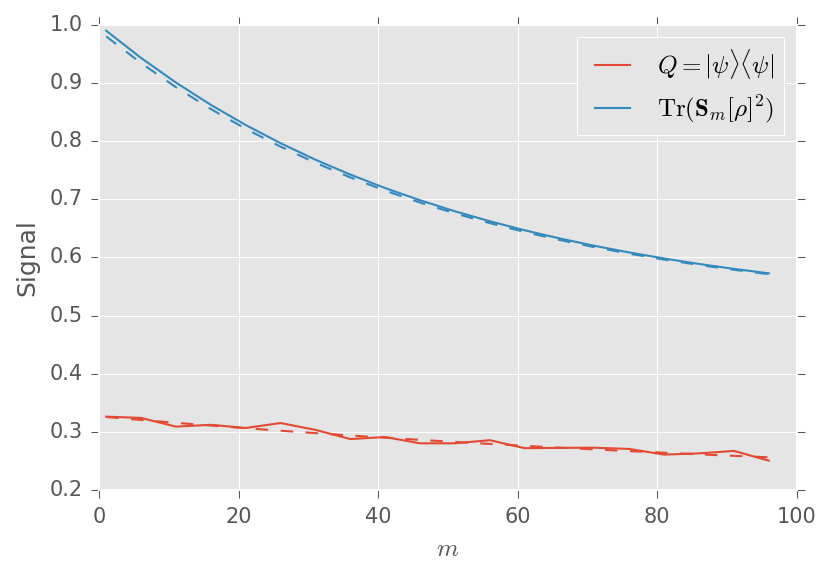

In [14]:
plt.plot(ms, q_measurements, label=r'$Q = |\psi\rangle\langle\psi|$')
plt.plot(ms, purity_measurements, label=r'$\operatorname{Tr}(\mathbf{S}_m[\rho]^2)$')

# Reset the color cycle.
plt.gca().set_prop_cycle(None)
plt.plot(ms, rb_model(ms, *q_fit), '--')
plt.plot(ms, rb_model(ms, *purity_fit), '--')


plt.xlabel('$m$')
plt.ylabel('Signal')
plt.legend()